In [3]:
!pip install sentence_transformers elasticsearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.8/412.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 9.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=2283d81248299af036f694d1d6e6a4112fb46b489e1f798e8d76ede0dce6a675
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [4]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
from elasticsearch import Elasticsearch, helpers
import torchvision.transforms as transforms

In [11]:
# Next, we get about 25k images from Unsplash
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)

    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)

    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)

  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

In [5]:
model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [14]:
# Prepare the image transformation function
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    lambda image: image.convert("RGB"),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [6]:
def create_mapping_if_new(index_name, es):

    # Define the mapping
    mapping = {
      "mappings": {
        "properties": {
          "image_vector": {
            "type": "dense_vector",
            "dims": 512,
            "index": True,
            "similarity": "cosine"
          } ,
          "filename": {
            "type": "keyword"
          }
      }
    }
  }

    # Check if the index does not exist
    if not es.indices.exists(index=index_name):
        # Create the index with the defined mapping
        es.indices.create(index=index_name, body=mapping)

In [47]:
def embed_image(image_path):

    # Open the image file
    with Image.open(image_path) as _image:
        # Apply the transformations to the image
        _image = transform(_image).unsqueeze(0)

        # If a GPU is available, move the image to the GPU
        if torch.cuda.is_available():
            _image = _image.to('cuda')
            model.to('cuda')

        # Generate the image vector using the model
        image_vector = model.encode(_image)

        # Check if it's a torch tensor and move to CPU if so
        if isinstance(image_vector, torch.Tensor):
            image_vector = image_vector.cpu().numpy()

        # Convert to list
        image_vector = image_vector.tolist()

        # Return the image vector
        return image_vector


In [8]:
import getpass

In [9]:
# set index name
index_name = 'sample_images_clip_vit_b32_multi_v1_1'

# Elasticsearch connection setup
es_cloud_id = getpass.getpass('Enter Elastic Cloud ID:  ')
es_api_key = getpass.getpass('Enter cluster API key:  ')

es = Elasticsearch(cloud_id=es_cloud_id,
                   api_key=es_api_key
                   )
es.info() # should return cluster info

Enter Elastic Cloud ID:  ··········
Enter cluster API key:  ··········


ObjectApiResponse({'name': 'instance-0000000000', 'cluster_name': '432aa681ed4144f185b29b9681c1892f', 'cluster_uuid': 'qJ_AnZ3tRbelt6IUv3SPOQ', 'version': {'number': '8.11.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '64cf052f3b56b1fd4449f5454cb88aca7e739d9a', 'build_date': '2023-12-08T11:33:53.634979452Z', 'build_snapshot': False, 'lucene_version': '9.8.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [11]:
img_names = list(glob.glob('photos/*.jpg'))
len(img_names)

24996

In [ ]:
# Initialize a array to hold the image filename and vector
data = []

# For each image file in the directory
for image_path in img_names:
  # print(image_path)

  # Get image vector
  image_vector = embed_image(image_path)

  # Store it in the data array
  data.append({"filename": os.path.basename(image_path), "vector": image_vector[0]})

# print(data)

# Index the image vectors to Elasticsearch
documents = []
for _data in data:

  # Create document
  document = {
      '_index': index_name,
      '_source': {
          "filename": _data['filename'],
          "image_vector": _data['vector']
      }
  }
  documents.append(document)

# documents

In [22]:
# Create new Index with correct mapping if index does not exist
create_mapping_if_new(index_name, es)

In [23]:
from elasticsearch.helpers import BulkIndexError

# Index document
try:
  helpers.bulk(es, documents)
except BulkIndexError as e:
  for x in e.errors:
    print(x)

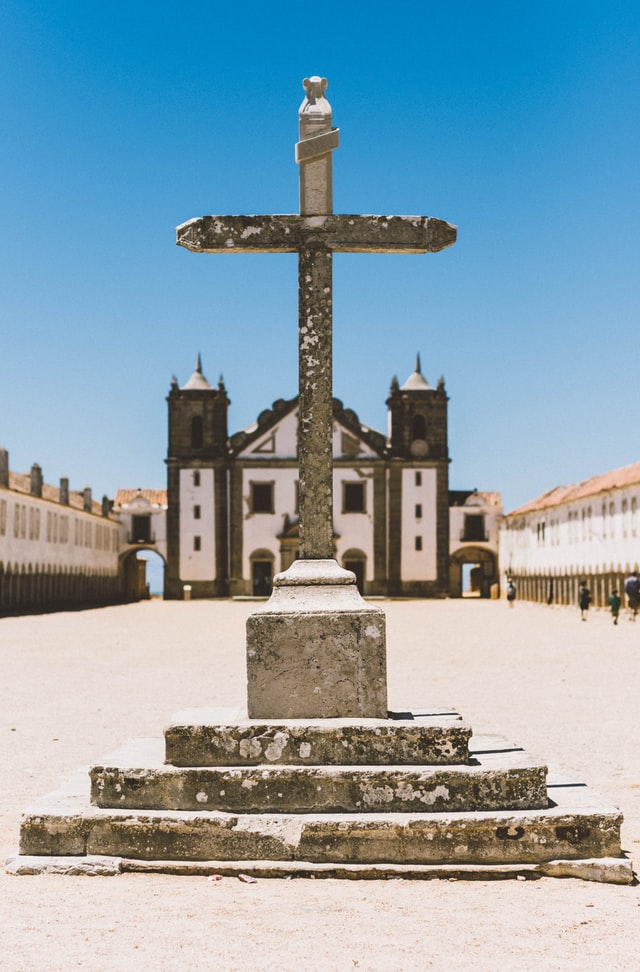

In [12]:
IPImage('/content/photos/OPyRXGstZcI.jpg', width=400)

In [21]:
search_image = '/content/photos/6J93jXFHs24.jpg'
search_image_vector = embed_image(search_image)

knn = {
    "field": "image_vector",
    "query_vector": search_image_vector[0],
    "k": 3,
    "num_candidates": 10,
}
fields = ["filename"]
size = 5
source = False

results = es.search(index=index_name, knn=knn, source=source, fields=fields, size=size)
results

ObjectApiResponse({'took': 3, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 3, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'sample_images_clip_vit_b32_multi_v1_1', '_id': 'X4-H-IwBWXdwwBdLJdSU', '_score': 1.0, 'fields': {'filename': ['6J93jXFHs24.jpg']}}, {'_index': 'sample_images_clip_vit_b32_multi_v1_1', '_id': 'Q4-G-IwBWXdwwBdLMpQH', '_score': 0.999859, 'fields': {'filename': ['-7QeX7V2YLY.jpg']}}, {'_index': 'sample_images_clip_vit_b32_multi_v1_1', '_id': 'w4-H-IwBWXdwwBdLAcgG', '_score': 0.9998127, 'fields': {'filename': ['p_l1REt3mPQ.jpg']}}]}})

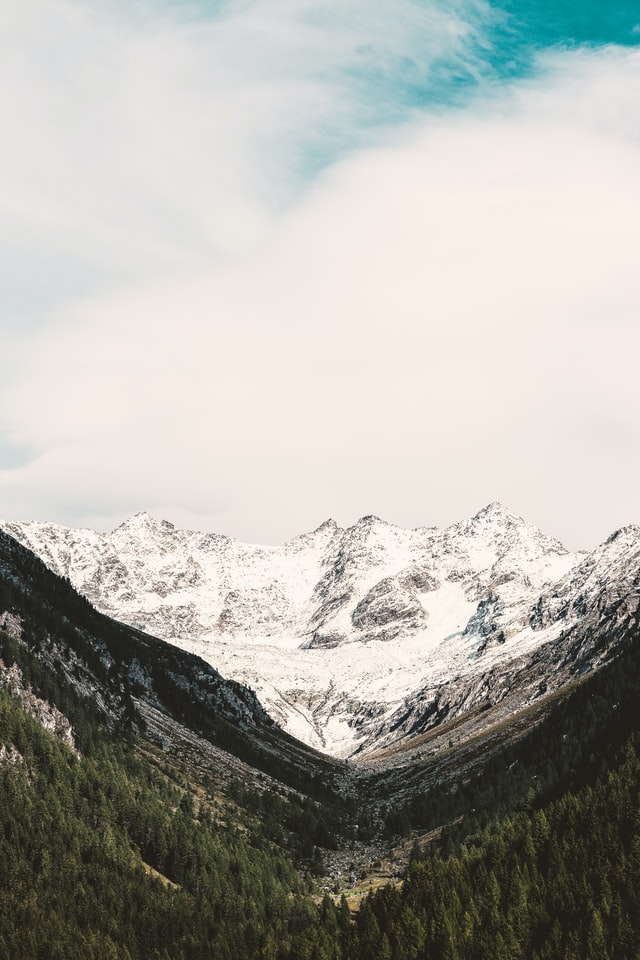

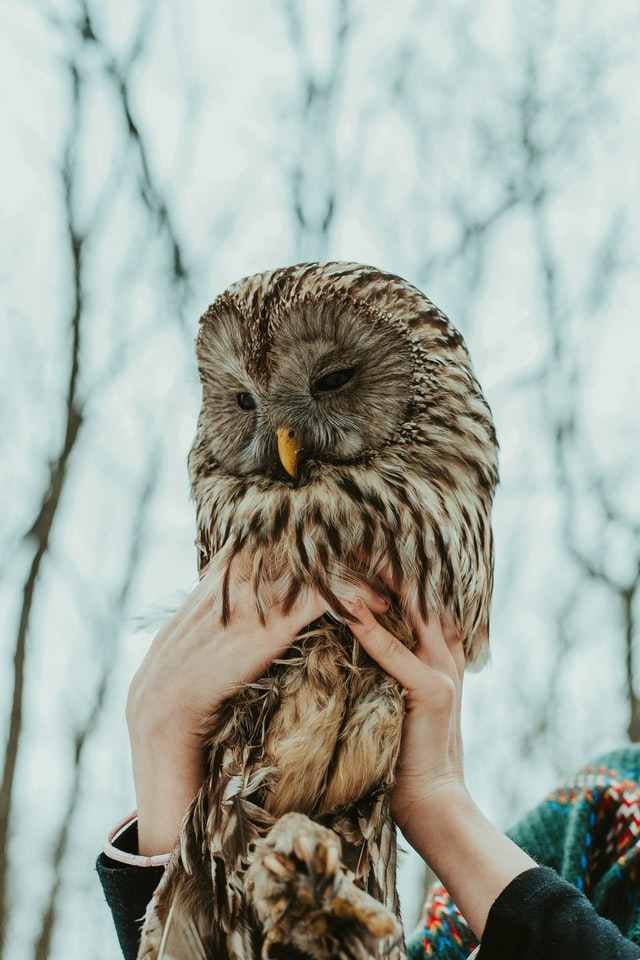

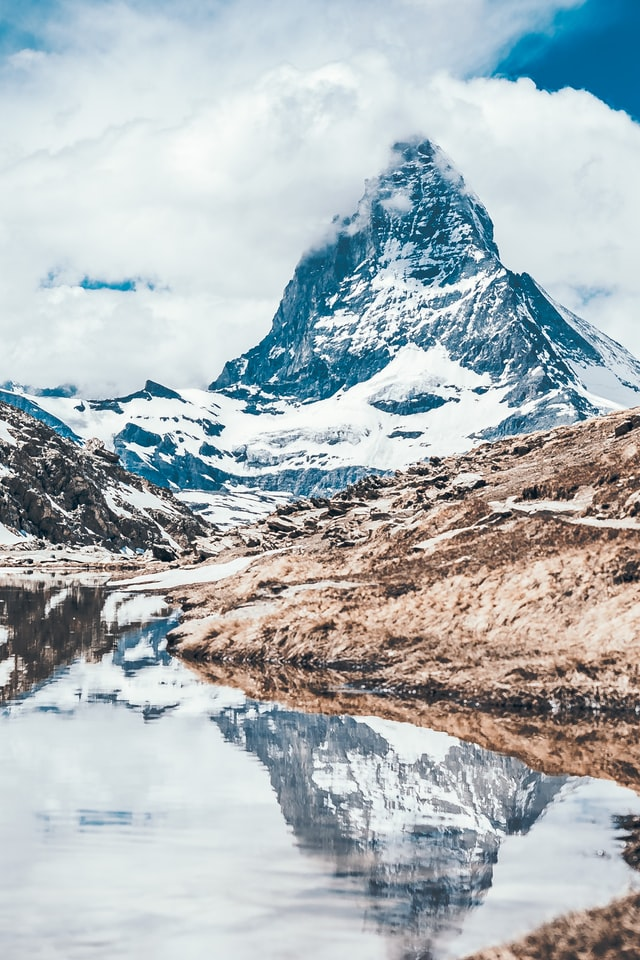

In [22]:
for hits in results['hits']['hits']:
  display(IPImage('/content/photos/' + hits['fields']['filename'][0], width=400))

In [48]:
text_embeddings = model.encode("dog")

knn = {
    "field": "image_vector",
    "query_vector": text_embeddings,
    "k": 3,
    "num_candidates": 10,
}
fields = ["filename"]
size = 10
source = False

results = es.search(index=index_name, knn=knn, source=source, fields=fields, size=size)
results

ObjectApiResponse({'took': 3, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 3, 'relation': 'eq'}, 'max_score': 0.9485325, 'hits': [{'_index': 'sample_images_clip_vit_b32_multi_v1_1', '_id': 'oY-G-IwBWXdwwBdLQJk_', '_score': 0.9485325, 'fields': {'filename': ['q5Ymb7sH8uk.jpg']}}, {'_index': 'sample_images_clip_vit_b32_multi_v1_1', '_id': '6o-H-IwBWXdwwBdLSt2r', '_score': 0.9485325, 'fields': {'filename': ['CNGdxgjWdz4.jpg']}}, {'_index': 'sample_images_clip_vit_b32_multi_v1_1', '_id': 'fo-G-IwBWXdwwBdLk60p', '_score': 0.9485325, 'fields': {'filename': ['ZQm_wg8jxhI.jpg']}}]}})

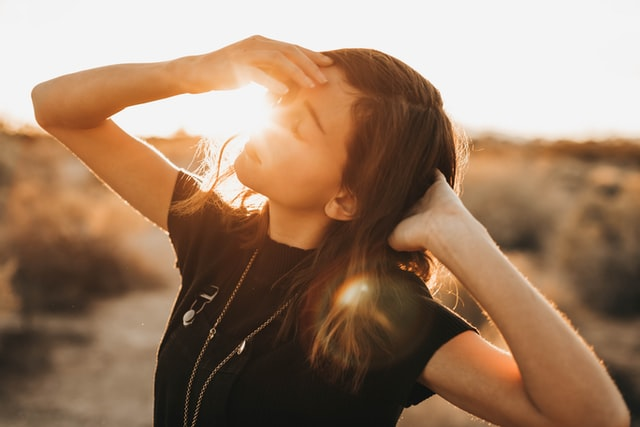

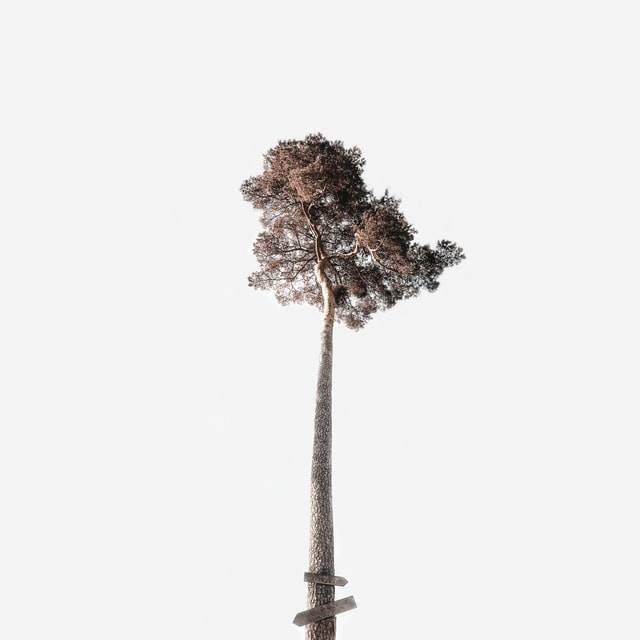

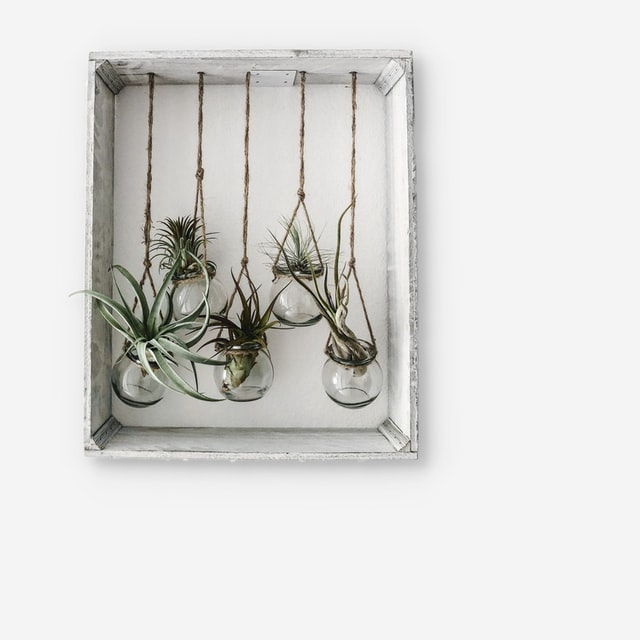

In [49]:
for hits in results['hits']['hits']:
  display(IPImage('/content/photos/' + hits['fields']['filename'][0], width=400))